# Measuring Synaptic Connection Probability

In this notebook we use the [Allen Institute synaptic physiology dataset](https://portal.brain-map.org/explore/connectivity/synaptic-physiology) to measure synaptic connection probability and its relationship to cell subclass and intersomatic distance.

For an introduction to the Jupyter Notebook interface interface, try [Codeacademy: How To Use Jupyter Notebooks]( https://www.codecademy.com/articles/how-to-use-jupyter-notebooks) or [Jupyter Notebook Quick Start Guide](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html).


In [1]:
import numpy as np
from aisynphys.database import SynphysDatabase
from aisynphys.cell_class import CellClass, classify_cells, classify_pairs
from aisynphys.connectivity import measure_connectivity

### 1. Load the data

First, load up the "small" database from release 1.0 and query all cell `pairs` for mouse projects.

In [2]:
# Download and cache the sqlite file for the requested database
#   (for available versions, see SynphysDatabase.list_versions)
db = SynphysDatabase.load_version('synphys_r1.0_2019-08-29_small.sqlite')

# Load all cell pairs associated with mouse V1 projects
mouse_pairs = db.pair_query(project_name=["mouse V1 coarse matrix", "mouse V1 pre-production"]).all()

print("loaded %d cell pairs" % len(mouse_pairs))

loaded 77084 cell pairs


A single cell `pair` represents a _possible_ connection from one cell to another:

In [3]:
# print some information about the last cell pair returned
pair = mouse_pairs[-1]
print("Cell pair:", pair)
print("  presynaptic subclass:", pair.pre_cell.cre_type)
print("  postsynaptic subclass:", pair.post_cell.cre_type)
print("  synaptic connection:", "yes" if pair.has_synapse else "no")

Cell pair: <pair 1555364175.620 8 7>
  presynaptic subclass: pvalb
  postsynaptic subclass: nr5a1
  synaptic connection: no


### 2. Define cell _classes_

We want to group together all cell pairs based on their pre- and postsynaptic cell classes. However, there are many different ways to classify cells so we must first define the criteria for all cell classes that we want to compare:

In [4]:
cell_class_criteria = {
    'l23pyr': {'dendrite_type': 'spiny',       'cortical_layer': '2/3'},
    'l23pv':  {'cre_type': 'pvalb',            'cortical_layer': '2/3'},
    'l23sst': {'cre_type': 'sst',              'cortical_layer': '2/3'},
    'l23vip': {'cre_type': 'vip',              'cortical_layer': '2/3'},
    'l4pyr':  {'cre_type': ('nr5a1', 'rorb'),  'cortical_layer': '4'},
    'l4pv':   {'cre_type': 'pvalb',            'cortical_layer': '4'},
    'l4sst':  {'cre_type': 'sst',              'cortical_layer': '4'},
    'l4vip':  {'cre_type': 'vip',              'cortical_layer': '4'},
    'l5et':   {'cre_type': ('sim1', 'fam84b'), 'cortical_layer': '5'},
    'l5it':   {'cre_type': 'tlx3',             'cortical_layer': '5'}, 
    'l5pv':   {'cre_type': 'pvalb',            'cortical_layer': '5'},
    'l5sst':  {'cre_type': 'sst',              'cortical_layer': '5'},
    'l5vip':  {'cre_type': 'vip',              'cortical_layer': '5'},
    'l6pyr':  {'cre_type': 'ntsr1',            'cortical_layer': ('6a','6b')},
    'l6pv':   {'cre_type': 'pvalb',            'cortical_layer': ('6a','6b')},
    'l6sst':  {'cre_type': 'sst',              'cortical_layer': ('6a','6b')},
    'l6vip':  {'cre_type': 'vip',              'cortical_layer': ('6a','6b')},
}

Create a `CellClass` object to represent each cell class described above:

In [5]:
cell_classes = {name:CellClass(name=name, **criteria) for name,criteria in cell_class_criteria.items()}

### 3. Measure connection probability between classes

In [6]:
# Group all cells by selected classes
cell_groups = classify_cells(cell_classes.values(), pairs=mouse_pairs)

# Group pairs into (pre_class, post_class) groups
pair_groups = classify_pairs(mouse_pairs, cell_groups)

# analyze matrix elements
results = measure_connectivity(pair_groups)

At this point we have all data loaded and connection probabilities have been computed. For each combination of (presynaptic_class, postsynaptic_class), we have a result dictionary that includes the number of putative connections probed, the number of synapses found, and the connection probability with 95% confidence intervals.

**The results for a single connection type look like:**

In [7]:
# pick two arbitrary cell classes to display results from
pre_class = cell_classes['l23sst']
post_class = cell_classes['l23vip']

print("Connectivity results for %s => %s" % (pre_class, post_class))
print("  %d synapses found out of %d probed" % (
    results[pre_class, post_class]['n_connected'],
    results[pre_class, post_class]['n_probed'],
))
print("  %0.2f%% connection probability" % (
    results[pre_class, post_class]['connection_probability'][0] * 100,
))
print("  95%% confidence interval: %0.2f%%-%0.2f%%" % (
    results[pre_class, post_class]['connection_probability'][1] * 100,
    results[pre_class, post_class]['connection_probability'][2] * 100,
))
    

Connectivity results for l23sst => l23vip
  4 synapses found out of 27 probed
  14.81% connection probability
  95% confidence interval: 4.19%-33.73%


### 4. Display conectivity heat map

Now we want to take the entire set of results computed above (for all connection types) and display a heat map where the color represents the probability of connection. 

To do this, we must first transform the results into 2D arrays of colors and labels, and then construct the heat map with a few calls to matplotlib. The function defined below 

/home/luke/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/colors.py:1060: RuntimeWarning: invalid value encountered in less_equal
  mask = (resdat <= 0)
/home/luke/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


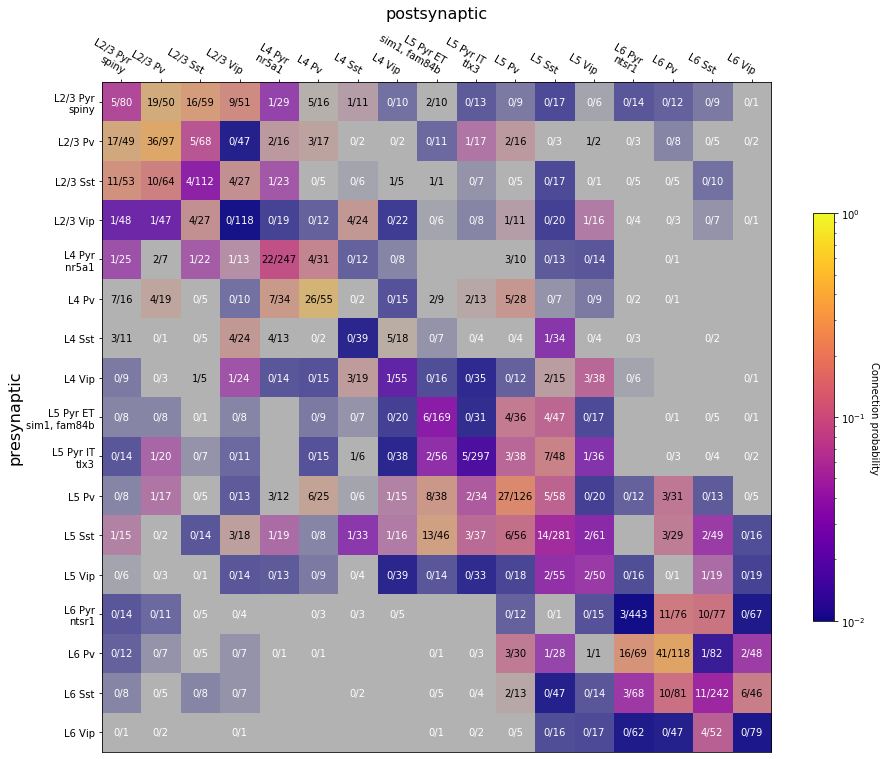

In [8]:
import matplotlib.colors, matplotlib.cm
import matplotlib.pyplot as plt
from aisynphys.ui.notebook import show_connectivity_matrix
%matplotlib inline

# define a colormap and log normalization used to color the heatmap
norm = matplotlib.colors.LogNorm(vmin=0.01, vmax=1.0, clip=True)
cmap = matplotlib.cm.get_cmap('plasma')

# define the display labels to use for each cell subclass:
class_labels = {
    'l23pyr': 'L2/3 Pyr\nspiny',
    'l23pv':  'L2/3 Pv',
    'l23sst': 'L2/3 Sst',
    'l23vip': 'L2/3 Vip',
    'l4pyr':  'L4 Pyr\n nr5a1',
    'l4pv':   'L4 Pv',
    'l4sst':  'L4 Sst',
    'l4vip':  'L4 Vip',
    'l5et':   'L5 Pyr ET\nsim1, fam84b',
    'l5it':   'L5 Pyr IT\ntlx3',
    'l5pv':   'L5 Pv',
    'l5sst':  'L5 Sst',
    'l5vip':  'L5 Vip',
    'l6pyr':  'L6 Pyr\nntsr1',
    'l6pv':   'L6 Pv',
    'l6sst':  'L6 Sst',
    'l6vip':  'L6 Vip',
}

# create a figure/axes to draw on
fig, ax = plt.subplots(figsize=(15, 15))

# finally, draw the colormap using the provided function:
im, cbar, labels = show_connectivity_matrix(
    ax=ax, 
    results=results, 
    pre_cell_classes=cell_classes.values(), 
    post_cell_classes=cell_classes.values(), 
    class_labels=class_labels, 
    cmap=cmap, 
    norm=norm
)

In [9]:
# optionally we can save the figure at this point
fig.savefig('mouse_connectivity_matrix.svg', format='svg')

It's important to remember that the measurements of connection probability shown above come with confidence intervals -- for example, L2/3 Sst cells were interconnected 4 times out of 112 probed (3.6%), but there is a range of possible connection rates that are statistically compatible with our results:

In [10]:
l23sst = cell_classes['l23sst']
cp, ci_low, ci_high = results[l23sst, l23sst]['connection_probability']
print(ci_low, ci_high)

0.009815163781275922 0.0889214735834295


The 95% confidence intervals above suggest that the probability of connection between L2/3 Sst cells is likely to be in the range 1-9%. Keep this statistical uncertainty in mind when interpreting the results above, and use appropriate tests when making comparisons between groups.

## Connectivity in the human dataset

The synaptic physiology dataset also contains recordings from human brain tissue. However, this tissue lacks the transgenic markers that we used to define mouse cell classes above. Instead, we will rely entirely on cortical layer and dendritic morphology (specifically, the presence of dense spines associated with excitatory cells) to separate classes. 

In the example below we filter only for cells with spiny dendrites, although the dataset also contains a smaller number of inhibitory interneurons as well as pyramidal cells for which no biocytin fill was available to judge the dendrite type.

In [11]:
# Load all cell pairs associated with mouse V1 projects
human_pairs = db.pair_query(project_name=["human coarse matrix"]).all()

print("loaded %d cell pairs" % len(human_pairs))

loaded 10410 cell pairs


In [12]:
cell_class_criteria = {
    'l2pyr':  {'dendrite_type': 'spiny', 'cortical_layer': '2'},
    'l3pyr':  {'dendrite_type': 'spiny', 'cortical_layer': '3'},
    'l4pyr':  {'dendrite_type': 'spiny', 'cortical_layer': '4'},
    'l5pyr':  {'dendrite_type': 'spiny', 'cortical_layer': '5'},
}

In [13]:
cell_classes = {name:CellClass(name=name, **criteria) for name,criteria in cell_class_criteria.items()}

In [14]:
# Group all cells by selected classes
cell_groups = classify_cells(cell_classes.values(), pairs=human_pairs)

# Group pairs into (pre_class, post_class) groups
pair_groups = classify_pairs(human_pairs, cell_groups)

# analyze matrix elements
results = measure_connectivity(pair_groups)

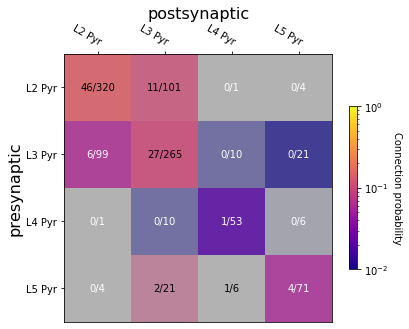

In [15]:
class_labels = {
    'l2pyr':  'L2 Pyr',
    'l2int':  'L2 Inh',
    'l3pyr':  'L3 Pyr',
    'l3int':  'L3 Inh',
    'l4pyr':  'L4 Pyr',
    'l4int':  'L4 Inh',
    'l5pyr':  'L5 Pyr',
    'l5int':  'L5 Inh',
}

# create a figure/axes to draw on
fig, ax = plt.subplots(figsize=(6, 6))

# finally, draw the colormap using the provided function:
im, cbar, labels = show_connectivity_matrix(
    ax=ax, 
    results=results, 
    pre_cell_classes=cell_classes.values(), 
    post_cell_classes=cell_classes.values(), 
    class_labels=class_labels, 
    cmap=cmap, 
    norm=norm
)

## Connectivity vs intersomatic distance

It is generally understood that two cells are more likely to be connected if their cell bodies are close together. This introduces a possible source of systematic bias in the connectivity measurements shown above because we do not always probe for synapses over the same range of distances. If one matrix element above was probed at sorter distances than another, then it may appear to have higher connectivity when in fact this is only the result of a sampling bias.

To be more careful, we can look at the actual distribution of distances probed for each group to make a more fair comparison:

In [16]:
# sort all inhibitory cells into pv, sst,and vip subclasses
cell_classes = {
    'pv': CellClass(cre_type='pvalb'),
    'sst': CellClass(cre_type='sst'),
    'vip': CellClass(cre_type='vip'),
}
cell_groups = classify_cells(cell_classes.values(), pairs=mouse_pairs)
pair_groups = classify_pairs(mouse_pairs, cell_groups)

In [17]:
from aisynphys.connectivity import connectivity_profile

# 30 um bins
bin_edges = np.arange(0, 500e-6, 30e-6)

profiles = {}
distances = {}

# loop over all 3 cell classes 
for name, cell_class in cell_classes.items():
    # get all like->like pairs for this cell class
    pairs = pair_groups[cell_class, cell_class]
    
    # build an array describing whether each pair is connected
    connected = np.array([pair.has_synapse for pair in pairs]).astype(bool)
    
    # and another list of distances
    distances[name] = np.array([pair.distance for pair in pairs]).astype(float)
    
    # generate a profile of connection probability vs distance 
    # with confidence intervals
    profiles[name] = connectivity_profile(connected, distances[name], bin_edges)
    
    

Text(0, 0.5, 'proportion connected')

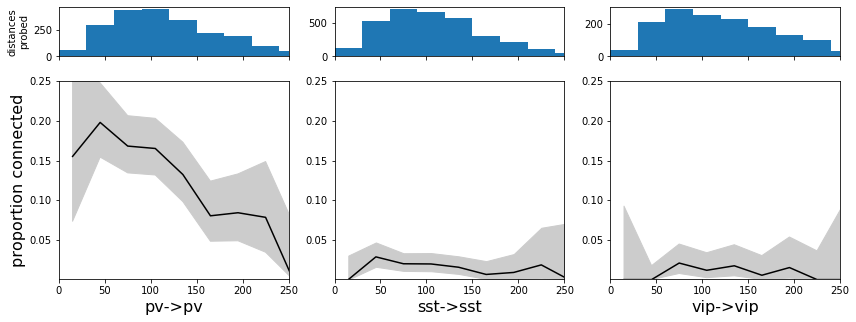

In [18]:
fig,axes = plt.subplots(2, 3, figsize=(14, 5), sharex=True, gridspec_kw={'height_ratios': [1, 4]})

for i,name in enumerate(profiles):
    bin_edges, prop, lower_ci, upper_ci = profiles[name]
    
    ax = axes[0, i]
    ax.hist(distances[name]*1e6, bins=bin_edges*1e6)
    
    xvals = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    ax = axes[1, i]
    ax.fill_between(xvals*1e6, lower_ci, upper_ci, color=(0.8, 0.8, 0.8))
    ax.plot(xvals*1e6, prop, color=(0, 0, 0))
    ax.set_ylim(0.001, 0.25)
    ax.set_xlim(0, 250)
    ax.set_xlabel(name + "->" + name, size=16)

axes[0,0].set_ylabel('distances\nprobed', size=10)
axes[1,0].set_ylabel('proportion connected', size=16)


The plots above show much more frequent connectivity between pvalb-positive interneurons (in all layers) compared to sst and vip, regardless of the intersomatic distance. 